# RecDP LLM - fuzzy deduplication

Near Dedup is to Detect duplicated documents and output as a duplicates list.

* Step 1. We use DataSketch minHash as the base algorithm to calculate (hash, band_id) pair for each documents.

* Step 2. We use Spark and SlimPajama connected component detect documents who sharing the same (hash, band_id) pair.

* Step 3(Optional). We apply the duplication list to original file to elimate duplicated documents.


### use case:
* Expect Input format: a folder of *.jsonl.
* Expect Output format: a folder of *.jsonl after reduction.


# Get started

## Install pyrecdp and dependencies

In [ ]:
! DEBIAN_FRONTEND=noninteractive apt-get install -y openjdk-8-jre
! pip install pyrecdp --pre
# ! pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

## 2. prepare your own data

In [ ]:
%mkdir -p /content/test_data
%cd /content/test_data
file_names = ['NIH_sample.jsonl']
file_list = [f"https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/PILE/{i}" for i in file_names]
file_names = ['tiny_c4_sample.jsonl', 'tiny_c4_sample_for_pii.jsonl']
file_list += [f"https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/{i}" for i in file_names]
!wget -P /content/test_data {" ".join(file_list)}

## 3. fuzzy deduplicate (seperate detection and reduction)

In [3]:
! ls /content/test_data

NIH_sample.jsonl  tiny_c4_sample_for_pii.jsonl	tiny_c4_sample.jsonl


### 3.1 PIPELINE based API

JAVA_HOME is not set, use default value of /usr/lib/jvm/java-8-openjdk-amd64/


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

2023-10-31 21:08:59.079 | WARNING  | pyrecdp.LLM.TextPipeline:enable_statistics:210 - Enabling this option will result in a decrease in execution speed


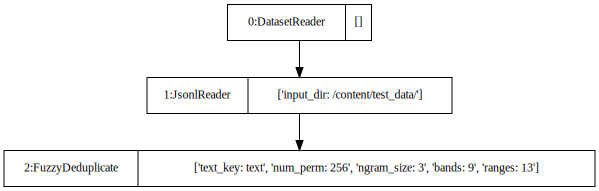

In [4]:
from pyrecdp.LLM import TextPipeline, ResumableTextPipeline
from pyrecdp.primitives.operations import *

pipeline = ResumableTextPipeline()
# optional to enable or not enable statistics.
# enable_statistics helps to show summary info
# not enable_statistics provides better performance
pipeline.enable_statistics()

# start to add ops to pipeline
ops = [
    JsonlReader("/content/test_data/"),
    FuzzyDeduplicate(text_key='text', num_perm = 256, ngram_size = 13, bands = 9, ranges = 13),
]
pipeline.add_operations(ops)
pipeline.plot()

In [5]:
ret = pipeline.execute()

[DatasetReader, GlobalJsonlReader, FuzzyDeduplicateGenDict, PerfileSourcedJsonlReader, FuzzyDeduplicateApplyDict, PerfileParquetWriter]
Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
execute with spark for global tasks started ...
DatasetReader
GlobalJsonlReader
FuzzyDeduplicateGenDict
statistics_decorator spark
num_bands is 9, ranges is 13
generate minHashLsh started ...
  generate minHashLsh took 90.57044342200004 sec
generate_connected_components => duplicates started ...


100%|██████████| 59/59 [00:00<00:00, 103758.46it/s]


  generate_connected_components => duplicates took 1.0796118470000238 sec
2023-10-31 21:10:58.437 | INFO     | pyrecdp.LLM.TextPipeline:execute:361 - DatasetReader: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.
2023-10-31 21:10:58.448 | INFO     | pyrecdp.LLM.TextPipeline:execute:361 - GlobalJsonlReader: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.
2023-10-31 21:10:58.473 | INFO     | pyrecdp.LLM.TextPipeline:execute:361 - FuzzyDeduplicateGenDict: A total of 10467 rows of data were processed, using 100.11400151252747 seconds, A duplication list containing 52 found, Sampled, duplication preview:                           global_id  \
0    7@tiny_c4_sample_for_pii.jsonl   
1          434@tiny_c4_sample.jsonl   
2             9371@NIH_sample.jsonl   
3             9825@NIH_sample.jsonl   
4             1767@NIH_sample.jsonl   
5             1761@

ResumableTextPipeline, current on tiny_c4_sample_for_pii.jsonl:   0%|          | 0/3 [00:00<?, ?it/s]

tiny_c4_sample_for_pii.jsonl
FuzzyDeduplicateApplyDict
statistics_decorator spark
2023-10-31 21:11:02.726 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - FuzzyDeduplicateApplyDict: A total of 18 rows of data were processed, using 1.067012071609497 seconds, with 7 rows modified or removed, 11 rows of data remaining.
2023-10-31 21:11:02.737 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - PerfileParquetWriter: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.


ResumableTextPipeline, current on tiny_c4_sample.jsonl:  33%|███▎      | 1/3 [00:03<00:07,  3.68s/it]        

tiny_c4_sample.jsonl
FuzzyDeduplicateApplyDict
statistics_decorator spark
2023-10-31 21:11:03.783 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - FuzzyDeduplicateApplyDict: A total of 467 rows of data were processed, using 1.6002342700958252 seconds, with 20 rows modified or removed, 447 rows of data remaining.
2023-10-31 21:11:03.786 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - PerfileParquetWriter: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.


ResumableTextPipeline, current on NIH_sample.jsonl:  67%|██████▋   | 2/3 [00:04<00:02,  2.13s/it]    

NIH_sample.jsonl
FuzzyDeduplicateApplyDict
statistics_decorator spark
2023-10-31 21:11:05.894 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - FuzzyDeduplicateApplyDict: A total of 10467 rows of data were processed, using 3.0440986156463623 seconds, with 52 rows modified or removed, 10415 rows of data remaining.
2023-10-31 21:11:05.906 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - PerfileParquetWriter: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.


ResumableTextPipeline, current on NIH_sample.jsonl: 100%|██████████| 3/3 [00:06<00:00,  2.29s/it]

2023-10-31 21:11:05.917 | INFO     | pyrecdp.LLM.TextPipeline:execute:405 - Completed! ResumableTextPipeline will not return dataset, please check ResumableTextPipeline_output_20231031210859 for verification.


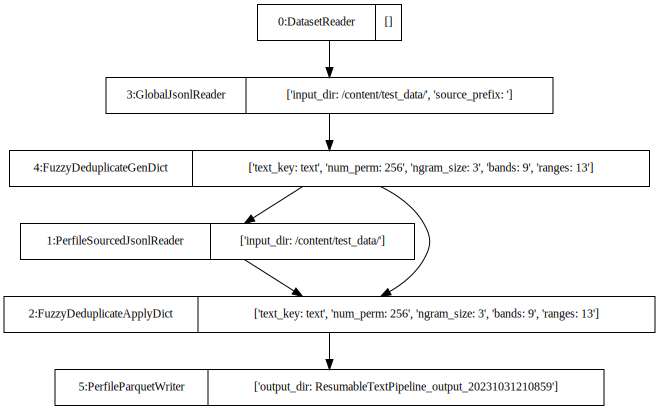

In [6]:
pipeline.plot()

In [7]:
del pipeline